# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:16<00:00, 3.61KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

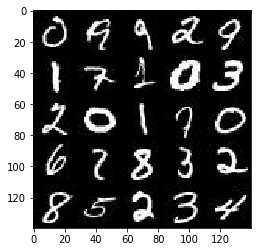

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

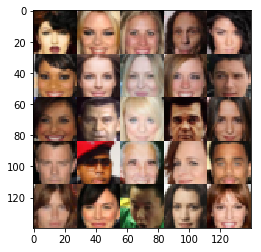

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),  name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (), name="lr")
    return real_input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.15):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 (or 28x28x1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.15):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                
                batch_images = batch_images * 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 1.2719
Epoch 1/2... Discriminator Loss: 1.5267... Generator Loss: 9.1228
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 8.8229
Epoch 1/2... Discriminator Loss: 0.6569... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 2.8236
Epoch 1/2... Discriminator Loss: 2.9267... Generator Loss: 0.0869
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 6.0979
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.9830
Epoch 1/2... Discriminator Loss: 1.7158... Generator Loss: 1.1468
Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.8115


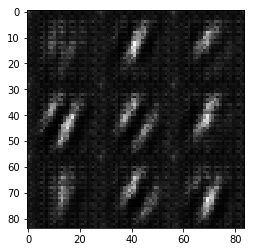

Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 2.4972
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.8512
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.7696... Generator Loss: 0.3535
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 1.3271
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 2.0686
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 1.7036


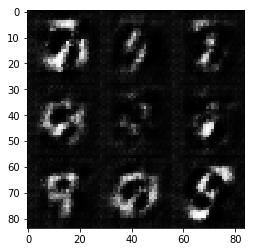

Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 1.7421... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.1696... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 1.5889
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 1.7053
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 1.7894
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 1.5090
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 1.8258
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.7605


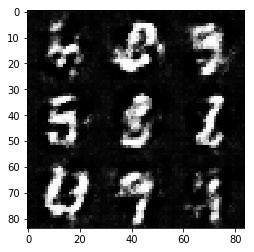

Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.6240
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 1.4954
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 1.9587
Epoch 1/2... Discriminator Loss: 1.5164... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 2.0551
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.4043


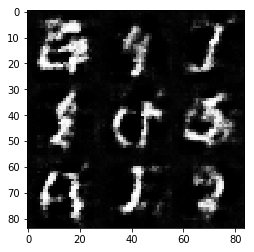

Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 0.3811
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.5649
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 1.9633... Generator Loss: 0.2491
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.3405


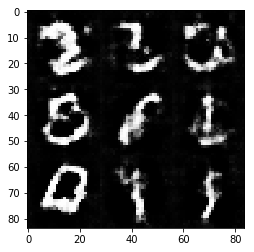

Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 1.8435
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 1.5193
Epoch 1/2... Discriminator Loss: 1.5261... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 1.2659
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 0.9411


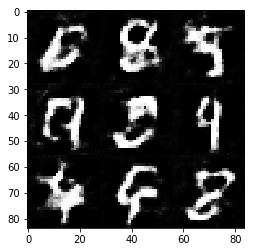

Epoch 1/2... Discriminator Loss: 1.5081... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 0.8492
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.3303
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.3775
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 1.8384
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.8478
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.2163
Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 1.5400


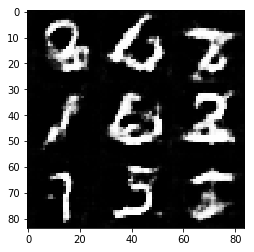

Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.4444
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 1.1955
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 2.5602
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.0479
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.9137
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 1.4848
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.5926


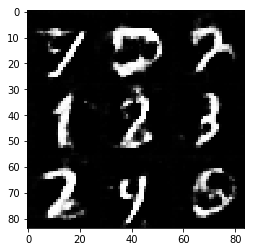

Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 0.9140
Epoch 1/2... Discriminator Loss: 0.9592... Generator Loss: 1.2749
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 2.1062
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.8011
Epoch 1/2... Discriminator Loss: 2.4571... Generator Loss: 0.1799


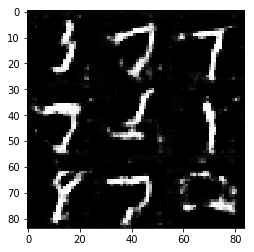

Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.9199
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.2395
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.0024... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 1.7186
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 1.3305


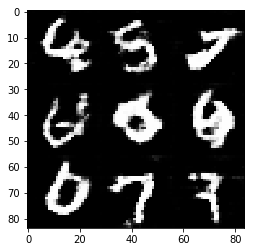

Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.4713
Epoch 1/2... Discriminator Loss: 1.1212... Generator Loss: 0.6579
Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 2.4422
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 0.9697
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 2.0319... Generator Loss: 3.1060
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.1986
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.2202


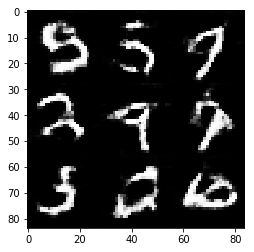

Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 2.2354... Generator Loss: 0.2383
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 2.1211
Epoch 1/2... Discriminator Loss: 1.2857... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 2.6953... Generator Loss: 0.1663
Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 0.7067


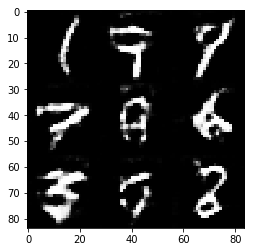

Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 1.0928... Generator Loss: 2.1738
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 0.8953... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 0.8316... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.9029


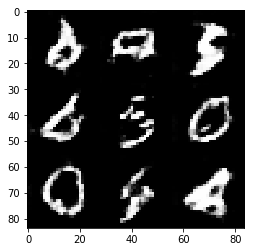

Epoch 1/2... Discriminator Loss: 1.9975... Generator Loss: 0.2624
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.8455... Generator Loss: 1.0834
Epoch 1/2... Discriminator Loss: 0.8012... Generator Loss: 1.5084
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.2601... Generator Loss: 2.3754
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.0164


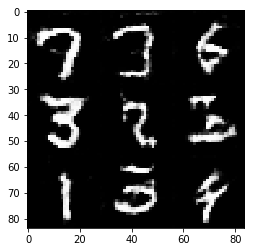

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 1.9779
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.5997
Epoch 1/2... Discriminator Loss: 0.8974... Generator Loss: 1.5510
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7831
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 0.7841... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 1.8071
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 1.1640
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.1590


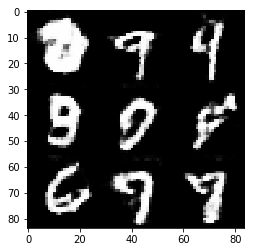

Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 0.9963... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 0.5831
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.4864
Epoch 1/2... Discriminator Loss: 2.0552... Generator Loss: 0.2672
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.0518
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.9043
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 3.1267


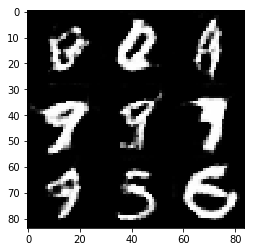

Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 2.2482
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 0.7090... Generator Loss: 1.5477
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 3.2366
Epoch 1/2... Discriminator Loss: 0.8005... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.4415
Epoch 1/2... Discriminator Loss: 0.9312... Generator Loss: 0.9881


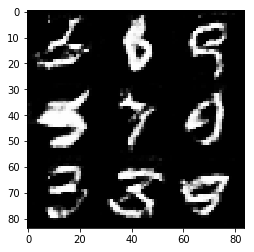

Epoch 1/2... Discriminator Loss: 0.5656... Generator Loss: 1.9200
Epoch 1/2... Discriminator Loss: 1.1295... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.6946
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.9916
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 2.0214
Epoch 1/2... Discriminator Loss: 0.8173... Generator Loss: 1.1461
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.3025
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.5167
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.5651


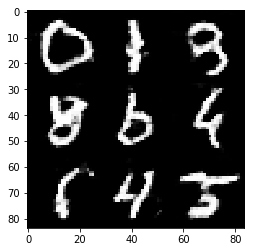

Epoch 1/2... Discriminator Loss: 1.9287... Generator Loss: 3.4474
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 0.7780
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.1253
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6433
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 0.6891... Generator Loss: 1.9767
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.7682
Epoch 2/2... Discriminator Loss: 1.7760... Generator Loss: 0.3442
Epoch 2/2... Discriminator Loss: 1.6388... Generator Loss: 0.3908


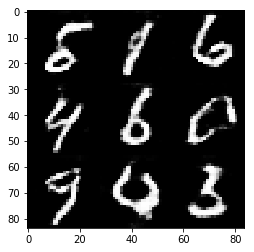

Epoch 2/2... Discriminator Loss: 0.9501... Generator Loss: 0.9340
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.8959
Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.5966
Epoch 2/2... Discriminator Loss: 0.7892... Generator Loss: 1.3455
Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 1.7757
Epoch 2/2... Discriminator Loss: 0.7933... Generator Loss: 1.3076


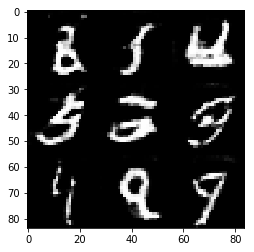

Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 1.5441... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 2.3957
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.0290
Epoch 2/2... Discriminator Loss: 0.6857... Generator Loss: 1.4085
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 2.5729... Generator Loss: 0.1950
Epoch 2/2... Discriminator Loss: 0.9634... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.1657


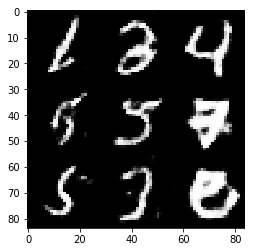

Epoch 2/2... Discriminator Loss: 0.6155... Generator Loss: 1.6659
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 1.1996
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 1.9859
Epoch 2/2... Discriminator Loss: 1.4308... Generator Loss: 3.9948
Epoch 2/2... Discriminator Loss: 0.6692... Generator Loss: 1.4543
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 2.1903
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.5999
Epoch 2/2... Discriminator Loss: 1.0595... Generator Loss: 0.7605
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.7581


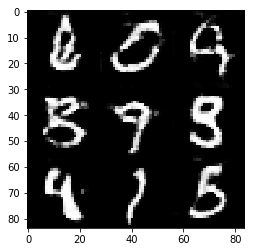

Epoch 2/2... Discriminator Loss: 1.2182... Generator Loss: 0.6139
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.4937
Epoch 2/2... Discriminator Loss: 0.7408... Generator Loss: 1.2569
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 1.3541
Epoch 2/2... Discriminator Loss: 2.7663... Generator Loss: 0.1447
Epoch 2/2... Discriminator Loss: 1.8065... Generator Loss: 0.4872
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.4949
Epoch 2/2... Discriminator Loss: 0.7996... Generator Loss: 1.1763


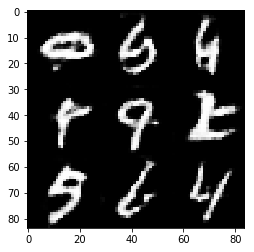

Epoch 2/2... Discriminator Loss: 2.0847... Generator Loss: 0.2945
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.8897
Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.1780
Epoch 2/2... Discriminator Loss: 0.6605... Generator Loss: 1.5170
Epoch 2/2... Discriminator Loss: 0.6824... Generator Loss: 1.4282
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 0.5063... Generator Loss: 2.1664
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.8537


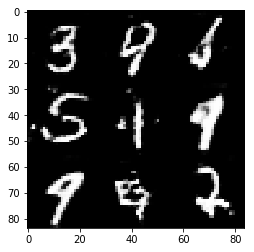

Epoch 2/2... Discriminator Loss: 2.2485... Generator Loss: 4.4149
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 1.2596
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.3338
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.7385
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 2.1596


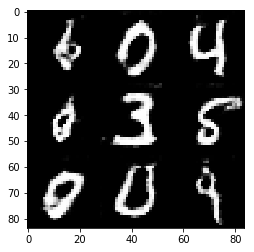

Epoch 2/2... Discriminator Loss: 2.1370... Generator Loss: 0.3048
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 2.4398
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.6657
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 1.3296
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 2.6393
Epoch 2/2... Discriminator Loss: 0.7405... Generator Loss: 1.2715
Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.7823
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.7927


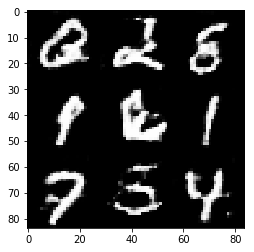

Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.8218
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 2.1285
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.7635
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.8443
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.2495
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.5499
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 2.5285
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 0.6931... Generator Loss: 1.3640
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 2.9836


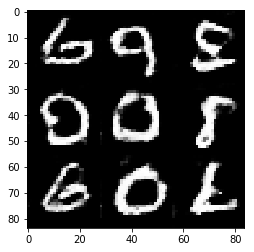

Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.2334
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.1692
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.7919... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 2.5941
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 2.1350... Generator Loss: 0.2642
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.9576


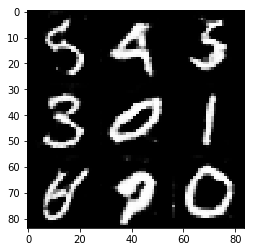

Epoch 2/2... Discriminator Loss: 1.0684... Generator Loss: 0.8543
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 2.1884
Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 1.5154... Generator Loss: 3.4511
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.6251
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.0987
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.4468


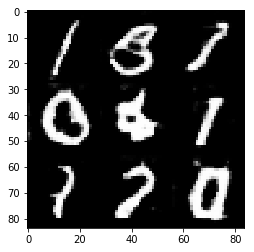

Epoch 2/2... Discriminator Loss: 0.6009... Generator Loss: 1.7586
Epoch 2/2... Discriminator Loss: 2.5897... Generator Loss: 0.1815
Epoch 2/2... Discriminator Loss: 2.3118... Generator Loss: 0.2519
Epoch 2/2... Discriminator Loss: 0.8624... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 0.6562... Generator Loss: 1.4147
Epoch 2/2... Discriminator Loss: 0.6606... Generator Loss: 1.5173
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 1.7943
Epoch 2/2... Discriminator Loss: 0.6485... Generator Loss: 1.6335
Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 1.9076
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.6963


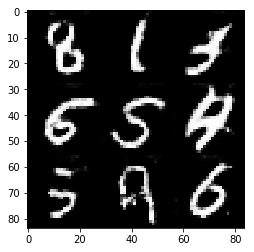

Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.6041
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.0074
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 1.4205
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.9164
Epoch 2/2... Discriminator Loss: 0.5529... Generator Loss: 1.8682
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 2.1685
Epoch 2/2... Discriminator Loss: 0.7295... Generator Loss: 1.3205


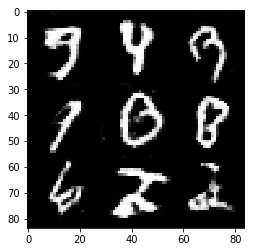

Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.4674
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 0.5722... Generator Loss: 2.0002
Epoch 2/2... Discriminator Loss: 0.6100... Generator Loss: 2.3856
Epoch 2/2... Discriminator Loss: 1.9726... Generator Loss: 0.3652
Epoch 2/2... Discriminator Loss: 0.8281... Generator Loss: 2.6614
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.7046... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.8139... Generator Loss: 1.1465
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.0318


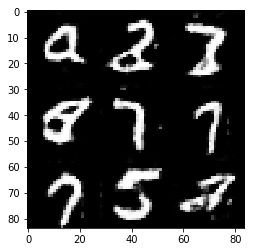

Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.2167
Epoch 2/2... Discriminator Loss: 0.6679... Generator Loss: 1.4367
Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 1.7186
Epoch 2/2... Discriminator Loss: 0.7668... Generator Loss: 1.3069
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 1.8279
Epoch 2/2... Discriminator Loss: 0.7146... Generator Loss: 1.4100
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.2844
Epoch 2/2... Discriminator Loss: 0.5196... Generator Loss: 1.9853
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.2471
Epoch 2/2... Discriminator Loss: 0.8715... Generator Loss: 0.9722


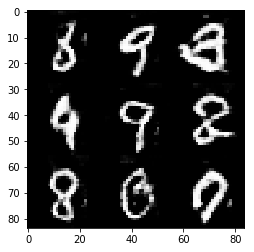

Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.9544... Generator Loss: 0.4115
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.5697
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.4262
Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 2.1132
Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.4005
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.6399
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 0.5474... Generator Loss: 2.3100


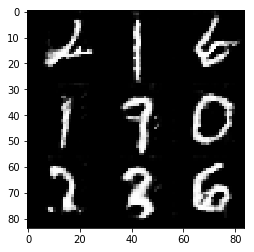

Epoch 2/2... Discriminator Loss: 0.7332... Generator Loss: 1.4313
Epoch 2/2... Discriminator Loss: 2.1492... Generator Loss: 4.4401
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.7465
Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 1.7408
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 3.7709
Epoch 2/2... Discriminator Loss: 1.3161... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 0.6755... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.4242
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.0989


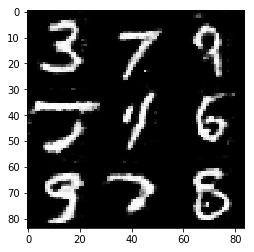

Epoch 2/2... Discriminator Loss: 1.4406... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.6111
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.2927... Generator Loss: 0.6272
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 1.6921... Generator Loss: 0.5237
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.0523
Epoch 2/2... Discriminator Loss: 0.9346... Generator Loss: 0.9935
Epoch 2/2... Discriminator Loss: 0.6256... Generator Loss: 1.7734


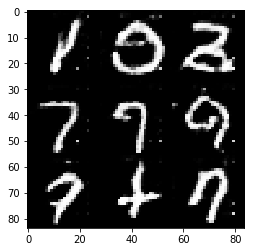

Epoch 2/2... Discriminator Loss: 0.6141... Generator Loss: 1.7019
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 2.1285
Epoch 2/2... Discriminator Loss: 2.7317... Generator Loss: 0.1953
Epoch 2/2... Discriminator Loss: 0.8579... Generator Loss: 1.0898
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.5827
Epoch 2/2... Discriminator Loss: 0.6987... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 3.2245
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 3.6686
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.3455


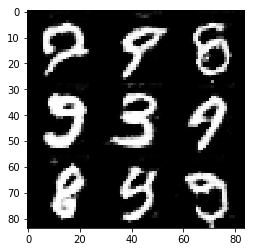

Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.3898
Epoch 2/2... Discriminator Loss: 0.5713... Generator Loss: 1.7306
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.3383
Epoch 2/2... Discriminator Loss: 1.9018... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 1.8366


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
tf.reset_default_graph()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 3.5780
Epoch 1/1... Discriminator Loss: 2.5853... Generator Loss: 0.1564
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 2.4856
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 8.1974
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 9.1785
Epoch 1/1... Discriminator Loss: 0.5391... Generator Loss: 4.3022
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.1213


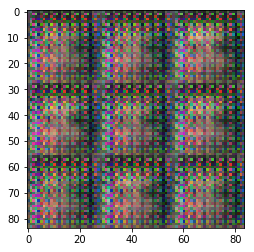

Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.2314
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.3454
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.7966
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 5.2773
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 2.0617... Generator Loss: 0.2262
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 3.8672
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 3.8127


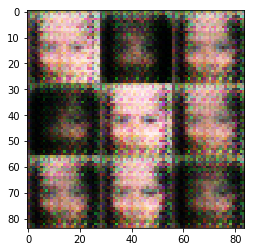

Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.2374
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.2917
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 2.0578... Generator Loss: 0.3266


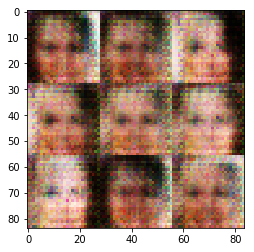

Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 1.6666... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.9974
Epoch 1/1... Discriminator Loss: 1.0255... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 2.9790
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.4805


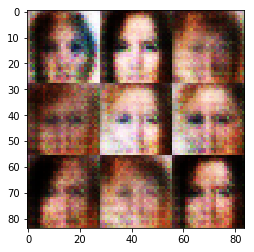

Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 2.3917
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.4251
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.2744


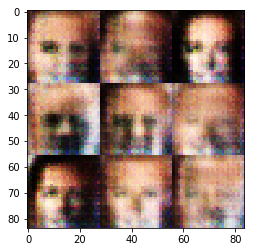

Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.3745
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.6078
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.8855


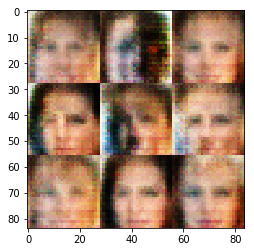

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.8084
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.1784
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.7608
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.3973


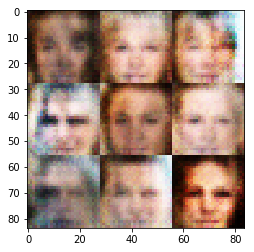

Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.4624
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8644


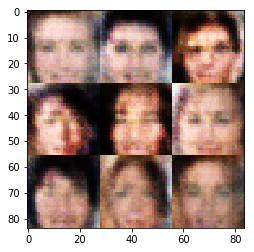

Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.1850
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.8034
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.1830


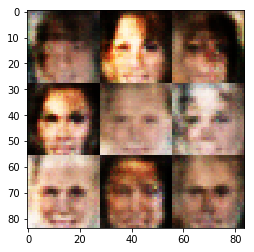

Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.2111
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.5651


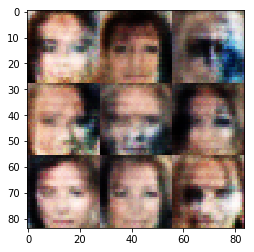

Epoch 1/1... Discriminator Loss: 1.8053... Generator Loss: 0.2946
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.3213
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.4970


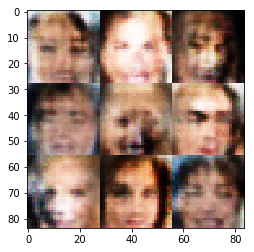

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.4487
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 1.9682
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.4861


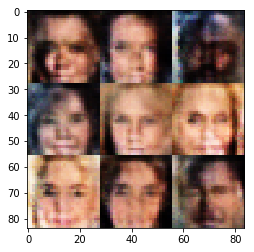

Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.8881
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 1.5659
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.3836
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.8786
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 2.1069


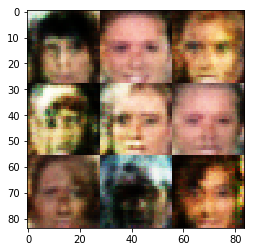

Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.7613


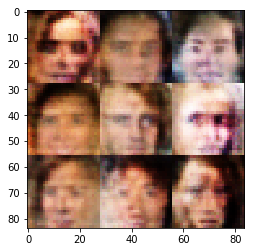

Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.2795
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.2922
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 2.0621... Generator Loss: 0.2241
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.5588


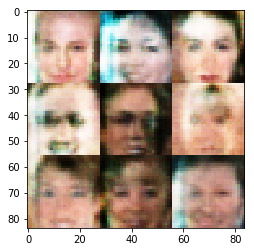

Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.8433... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.7326
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.9232


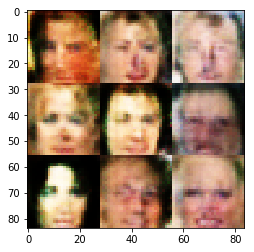

Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 2.0738
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.3888


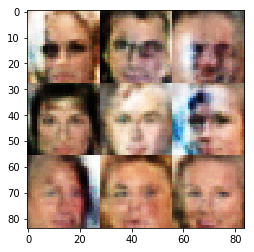

Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.9188... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 2.5534
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.5155


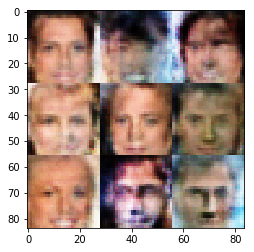

Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.8081... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5005
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 2.0044
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.6600


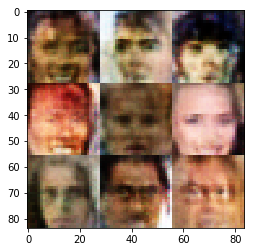

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.9339
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.7855... Generator Loss: 0.3051


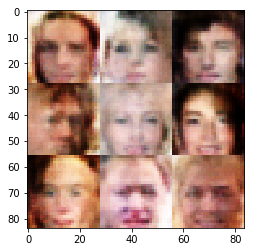

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 1.8819
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.5669
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.8863


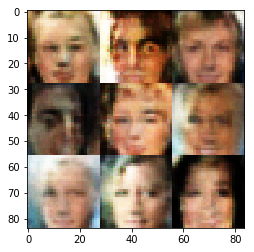

Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 2.2153... Generator Loss: 0.1855
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.1644
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 2.4250
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.2013


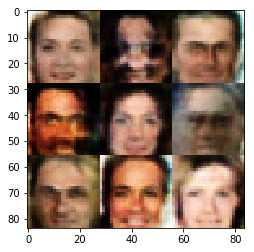

Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.3845
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 2.2760
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.5102


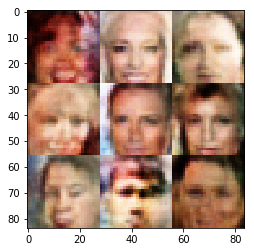

Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.7278... Generator Loss: 3.2534
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.9855


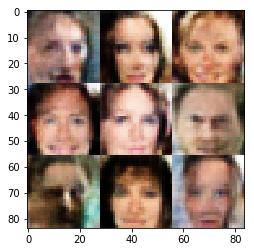

Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.4557
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 1.1123


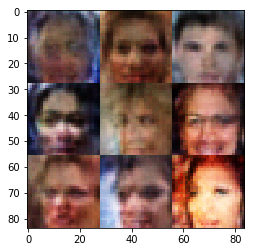

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.8379
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.8914... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.1323


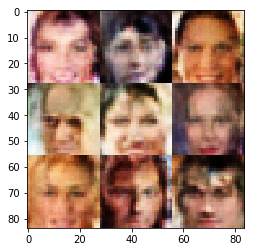

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.9252


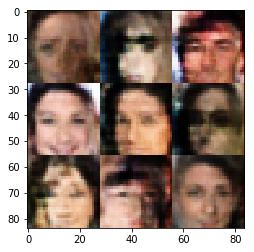

Epoch 1/1... Discriminator Loss: 1.6646... Generator Loss: 0.3502
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.7022
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.2287


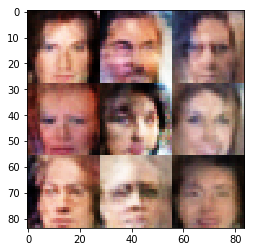

Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.7148... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.5606


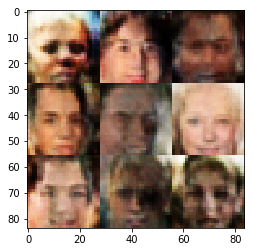

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.4934
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.9101... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 0.3828
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.3285
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.5660


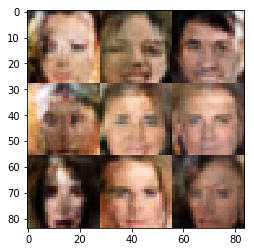

Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.7900
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.2222


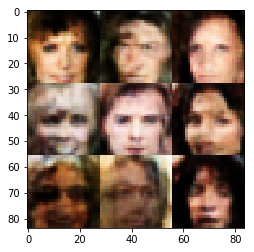

Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.4994
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7602


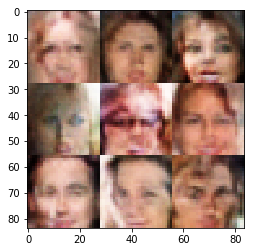

Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3784
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.1465


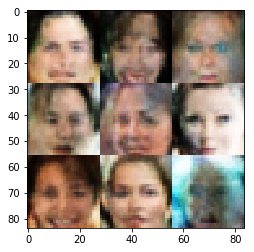

Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 0.7712... Generator Loss: 1.3348
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.3207


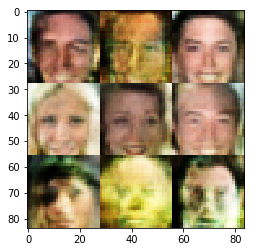

Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.3141
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 1.0521


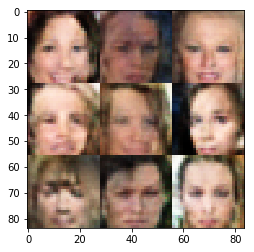

Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.9072
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.8707
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9865... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4298
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.3645


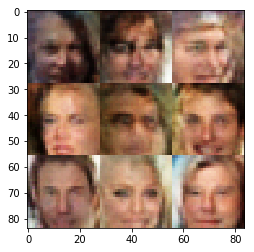

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5341
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6283


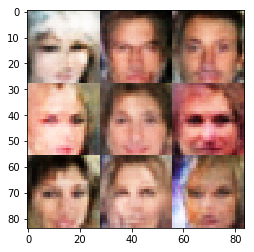

Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.5974... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.3458
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7275


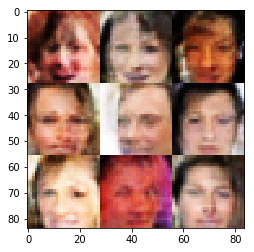

Epoch 1/1... Discriminator Loss: 1.8418... Generator Loss: 0.2836
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.5420
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.3659
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 0.8192


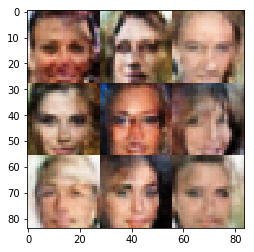

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8642


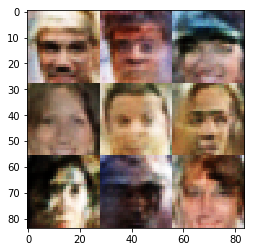

Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.5244


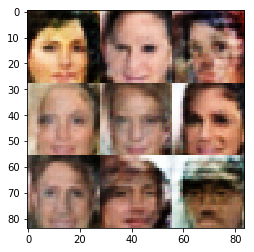

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.7734... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.2043


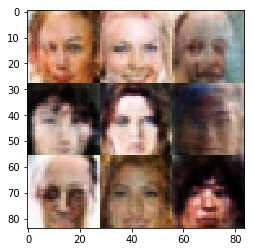

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.4921


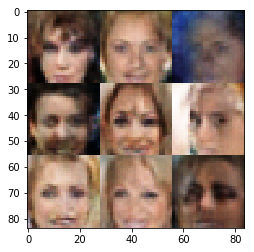

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.2151
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.0577


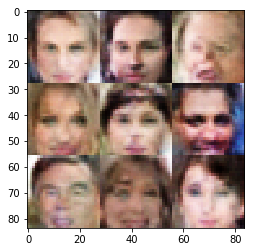

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.4211


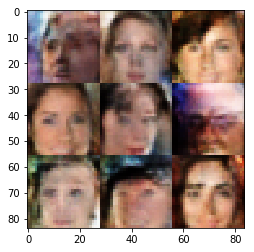

Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 1.9519
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.3956


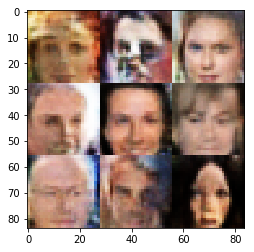

Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.5509


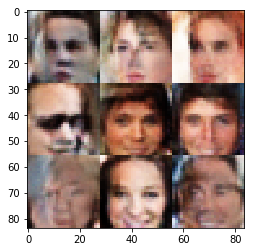

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.5729... Generator Loss: 0.4036


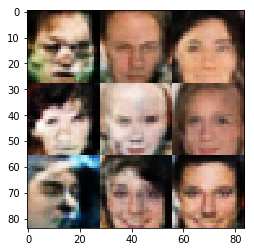

Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.2684
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5280


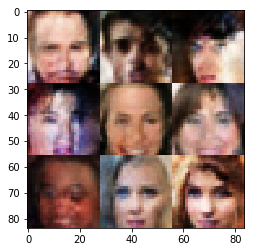

Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7455


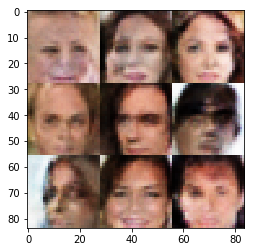

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.3438
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.4094


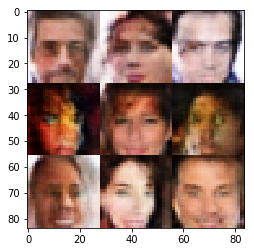

Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.0274
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.6725
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.6040


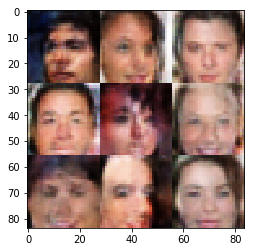

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.7207... Generator Loss: 0.3794


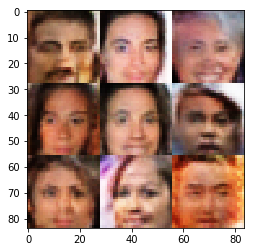

Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6585


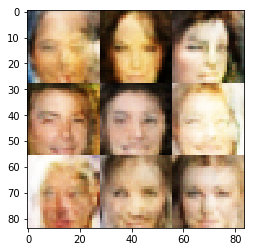

Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.4910
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1466


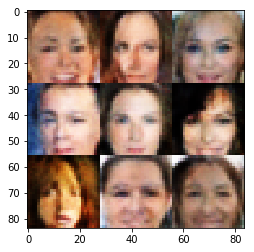

Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 2.1620
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.8626
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.9754
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.4624


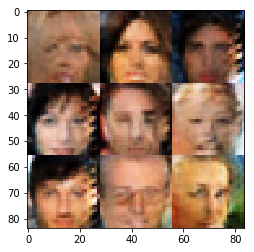

Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.6689


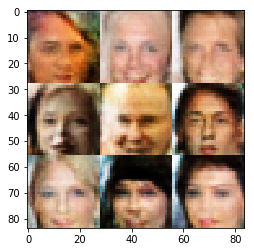

Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 0.3089
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.6825
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.9584... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.3440
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9667


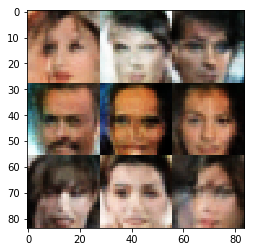

Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.4063


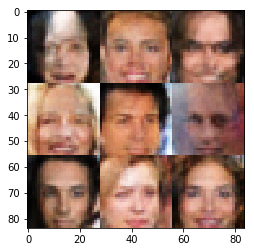

Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 0.3447
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.6091
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.9242


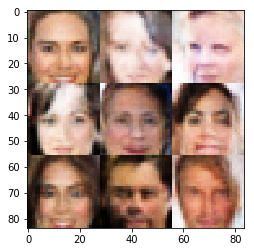

Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.9879
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.5407
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.8569


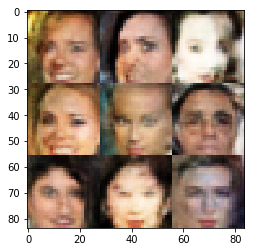

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.7373


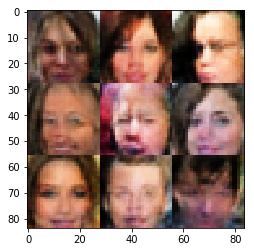

Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 2.2924
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.5111


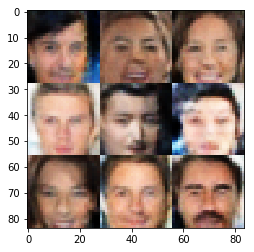

Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 2.0289... Generator Loss: 0.2281
Epoch 1/1... Discriminator Loss: 1.6251... Generator Loss: 1.2594


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.